### We need a multivariate time series dataset. Here the data is of ice cream and heater as two variables with time 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox


In [6]:
# Load dataset (example: macroeconomic data)
df = pd.read_csv('datasets/ice_cream_vs_heater.xls')

In [7]:
df.head()

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21


In [13]:
# Convert column year in datetime format
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

### VAR models require stationary data, so we check for stationarity using the Augmented Dickey-Fuller (ADF) test.

In [14]:
# Check for stationarity Will use function everytime thus function is defined
def adf_test(series):
    result = adfuller(series)
    return result[1]  # p-value

Checking stationary for both the columns

In [15]:
adf_test(df['heater'])  # Not stationary

0.9937106551805235

In [16]:
adf_test(df['ice cream']) # Not stationary

0.9249454712517605

### Differencing for making it stationary

In [17]:
df_diff = df.diff().dropna()  # First-order differencing

In [21]:
adf_test(df_diff['heater']) # Now Stationary

9.213801624031098e-30

In [20]:
adf_test(df_diff['ice cream']) # Now stationary

5.893887017364702e-05

# Model Building

#### There is only one parameter in VAR model,  Why is it so ? Since it uses Auto regressive (AR) which has only p

In [22]:
# Select optimal lag length
model = VAR(df)
lag_selection = model.select_order(maxlags=20)
optimal_lag = lag_selection.aic  # Using AIC-selected lag

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1. How will we decide the value of p in VAR models?
2. Also it does everything. Kitne plots banayega for every variable? is it ? No, VAR does it automatically 

In [23]:
print(lag_selection.summary()) 

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.30       10.34   2.981e+04       10.32
1        7.602       7.709       2002.       7.645
2        7.022       7.201       1121.       7.095
3        6.588       6.839       726.7       6.690
4        6.228       6.549       506.7       6.358
5        6.021       6.414       412.1       6.180
6        5.794      6.259*       328.5       5.982
7        5.771       6.307       321.0       5.988
8        5.804       6.411       331.9       6.050
9        5.693       6.372       297.3       5.969
10       5.630       6.381       279.3       5.935
11       5.599       6.421       271.0       5.933
12       5.464       6.358       236.9       5.826
13      5.422*       6.387      227.4*      5.814*
14       5.447       6.484       233.5       5.868
15       5.468       6.577       238.8       5.918
16       5.494       6.674     

In [24]:
print(optimal_lag)

13


In [25]:
# Once we find the parameter we fit the model
# Fit VAR model
var_model = VAR(df)
results = var_model.fit(optimal_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Mar, 2025
Time:                     11:43:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.27742
Nobs:                     185.000    HQIC:                   5.71838
Log likelihood:          -964.719    FPE:                    208.850
AIC:                      5.33742    Det(Omega_mle):         159.040
--------------------------------------------------------------------
Results for equation heater
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 2.319106         1.515153            1.531           0.126
L1.heater             0.328029         0.079523            4.125           0.000
L1.ice cream         -0.017671         0.047492           -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### After fitting,we ensure that the residuals (errors) are uncorrelated and normally distributed

In [28]:
# Check for autocorrelation in residuals (Ljung-Box test)
# Null = residuals are normal which is what we want 

for col in results.resid.columns:
    print(f"\nLjung-Box Test for {col}:")
    lb_test = acorr_ljungbox(results.resid[col], lags=[10], return_df=True)
    print(lb_test)


Ljung-Box Test for heater:
     lb_stat  lb_pvalue
10  2.981241   0.981862

Ljung-Box Test for ice cream:
     lb_stat  lb_pvalue
10  2.152012   0.995037


### If p-value > 0.05, residuals are white noise (good model fit).

In [29]:
# Forecast next 5 periods
forecast_steps = 5
forecast_values = results.forecast(df.values[-optimal_lag:], steps=forecast_steps)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_values, columns=df.columns)
print(forecast_df)

      heater  ice cream
0  21.166264  78.100275
1  25.926839  58.037025
2  31.618888  45.546684
3  44.038844  40.968398
4  54.338738  39.310621


/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2303/2310576326.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='Y'), forecast_df[col], linestyle='dashed', label=f'Forecast {col}')


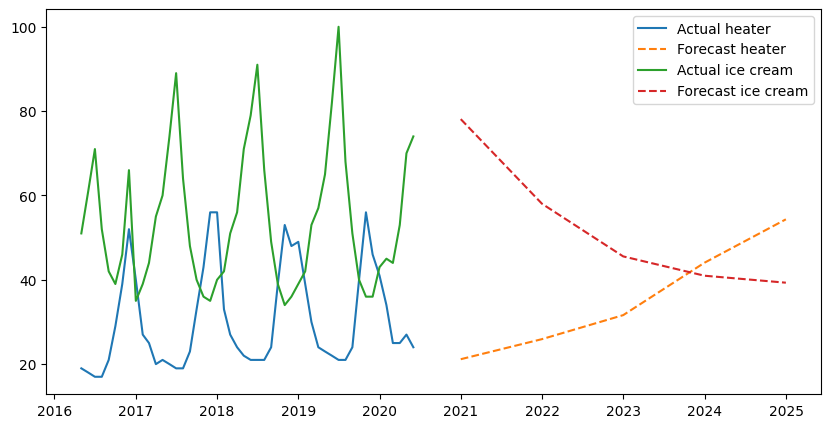

In [30]:
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df.index[-50:], df[col].iloc[-50:], label=f'Actual {col}')
    plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='Y'), forecast_df[col], linestyle='dashed', label=f'Forecast {col}')
plt.legend()
plt.show()

### Sale of ice cream will decrease and heater will increase